# Fitting Emission Lines from SOFIA FIFI-LS Data

## Introduction

The following notebook is broken up into the following parts:
1. Accessing Archival Data from the NASA/IPAC Science Archive
2. Using the SOFIA SPectral EXplorer
3. Environment Setup and Data Initialization
4. Continuum Fitting & Subtraction
5. Gaussian Fitting & Exporting Results



Dependencies:

`astropy` 7.2.0: Core framework for astronomical coordinates

`specutils` 2.3.0: Toolkit for spectroscopic data analysis and fitting

`astroquery` 0.4.11: Interface for programmatic access to the NASA/IPAC NED database.

`scipy` 1.17.0: Numerical optimization engine used for the Gaussian parameter estimation.

`matplotlib` 3.10.8: Engine for generating publication-quality

`numpy` 2.4.2: Mathematical functions

`pandas` 3.0.1: Data manipulation and analysis

This notebook is optimized for `Python v3.11.14`


## 1. Accessing Archival Data from the NASA/IPAC Science Archive
This section walks you through navigating the NASA/IPAC Infrared Science Archive (IRSA) to retrieve SOFIA FIFI-LS spectroscopic data: specifically, data for the blue compact dwarf galaxy NGC 4670.

1. Access the NASA/IPAC Infrared Science Archive using the following link: https://irsa.ipac.caltech.edu/frontpage/
   
2. Click more to see all observatories.

<div>
<img src="images/IRSA_1.png" width="600">
</div>

3. Click on SOFIA to access archival data from the Stratospheric Observatory for Infrared Astronomy.

<div>
<img src="images/IRSA_2.png" width="600">
</div>

4. Scroll down and click on the link for the NASA SOFIA Archive underneath IRSA Services.

<div>
<img src="images/IRSA_3.png" width="600">
</div>


> This tutorial walks you through fitting an emission line for the blue compact dwarf galaxy **NGC 4670**.

5. Type "NGC4670" into the search bar. Under instrument constraints, select FIFI-LS (the SOFIA instrument that we will be using). Under product constraints, select level 4 data only. Hit Search.

6. Once the archival data is loaded, select FIFI-LS from the top bar.

<div>
<img src="images/IRSA_4.png" width="600">
</div>


7. You should see 5 observations of NGC 4670 made by FIFI-LS. Scroll to the right to view the columns that say 'min wavelenth' and 'max wavelength'.

<div>
<img src="images/IRSA_5.png" width="600">
</div>

8. Select the observation that covers a wavelength range of 88.70 - 89.65 μm, then click Prepare Download.

<div>
<img src="images/IRSA_6.png" width="600">
</div>

9. Change the file name to describe the data you are downloading. For example: SOFIA_FIFI-LS_NGC4670_OIII88, then click prepare download again.

<div>
<img src="images/IRSA_7.png" width="400">
</div>

10. This should download a .zip file. Open the zip file and you will see a folder named SOFIA_FIFI-LS_NGC4670_OIII88 with a readme file and a data folder. The folders should be nested as shown below. When you are downloading many files from different observations, this folder structure can be useful. 

<div>
<img src="images/IRSA_8.png" width="400">
</div>


## 2. Using the SOFIA SPectral EXplorer
This section guides you through the installation of SOSPEX and the processing of FIFI-LS data cubes. We will use SOSPEX to view the data cube, define an aperture, and export the result in a text file.

1. Follow the instructions at the link below to install SOSPEX, the SOFIA SPectral EXplorer. 

> Detailed install instructions: https://github.com/darioflute/sospex/blob/master/INSTALL.md <br> 
> Additional tutorials: https://nbviewer.jupyter.org/github/darioflute/sospex/blob/master/sospex/help/tutorials.html

2. Open SOSPEX.

 
3. Click on the folder icon, then navigate to and select the .fits file you just downloaded. The file should be named: F0551_FI_IFS_06022221_BLU_WXY_400382-400419.fits

<div>
<img src="images/SOSPEX_1.png" width="600">
</div>

> Once you select the fits file, your screen should look like this:
<div>
<img src="images/SOSPEX_2.png" width="600">
</div>

> SOSPEX displays your FIFI-LS data in two panels. The flux map (left) shows a 2D spatial image of your observation where color represents emission strength (dark = strong emission, light = weak emission). The green box indicates the currently selected pixel. The spectrum (right) shows the wavelength vs flux data of the selected pixel.

4. Select the Slicer Selection Tool.

<div>
<img src="images/SOSPEX_3.png" width="600">
</div>

5. Select Cube Slice, then click ok.

<div>
<img src="images/SOSPEX_4.png" width="200">
</div>

6. Adjust the wavelength range of the green bar to encompass the emission feature. Now we are viewing all the spectral data from that wavelength range - instead of just one channel.

<div>
<img src="images/SOSPEX_5.png" width="600">
</div>


7. Select View &rarr; Colors and Stretch and select the sinh option, then click ok. Feel free to experiment with different color scales and stretch functions to find the settings that distinguish the emission in your data.

<div>
<img src="images/SOSPEX_6.png" width="200">
</div>

8. Select View &rarr; Image Levels &rarr; 95% to further visually define the emission.
<div>
<img src="images/SOSPEX_7.png" width="300">
</div>

9. Select Tools &rarr; Select Interactive Aperture &rarr; Circle to define a circular aperture. An aperture in SOSPEX defines a spatial region for extracting and analyzing spectra. Instead of looking at individual pixels, you are now averaging the signal from all the pixels within the defined region - in this case, the entire cloud of OIII gas.

<div>
<img src="images/SOSPEX_8.png" width="600">
</div>

10. Move and resize the aperture to fit the emission on the spectral cube, as shown below.

<div>
<img src="images/SOSPEX_9.png" width="600">
</div>

11. Select I/O, then save spectrum.

<div>
<img src="images/SOSPEX_10.png" width="200">
</div>

12. Name the file ending in .txt (I just named it the same as the .fits) and make sure you select ASCII Files (*.txt) from the drop-down menu.

<div>
<img src="images/SOSPEX_11.png" width="400">
</div>

## 3. Environment Setup and Data Initialization
This section configures the analysis environment, automatically installs missing dependencies, and loads the data we preprocessed and extracted from SOSPEX. It integrates physical constants and redshift data from the NED database to calibrate the wavelength scale for the target emission line. A diagnostic plot is generated to validate flux quality and atmospheric transmission before extracting the data into NumPy arrays for modeling.

In [1]:
import sys
import subprocess
import os

# Automated Environment Setup 
required_packages = ['matplotlib', 'numpy', 'pandas', 'time', 'scipy', 'astropy', 'specutils', 'astroquery']

def setup_environment():
    for package in required_packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

setup_environment()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import date
from math import exp
from math import log as ln
from math import sqrt
from scipy import integrate
from scipy import constants as const
from astropy.modeling import models
from astropy.modeling import fitting
from astropy.modeling.polynomial import Chebyshev1D
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astroquery.ipac.ned import Ned
from specutils import Spectrum
from specutils.spectra import SpectralRegion
from specutils.fitting import fit_generic_continuum

print("All packages verified and loaded successfully!")

All packages verified and loaded successfully!


### User Inputs: Initial Set-up ###
Before running the analysis, you need to specify three key inputs:
1. Galaxy - replace 'NGC4670' with your source name. Ex: Galaxy = 'M82'       
2. Line - replace 'OIII88' with the emission line that you are trying to fit. Line emission line must be in the FIFI-LS wavelength range from 42 - 201 µm.
3. namef - replace the current path with the complete path to your SOSPEX-exported text file.

Make sure to put either double or single quotes around your inputs.

In [17]:
# User Inputs
Galaxy = 'NGC4670' # Galaxy Name
Line = 'OIII88'  # Emission line that you are trying to fit --> must be in FIFI-LS wavelength range (42 - 201 µm)
namef = '/Users/YOUR_PATH/F0551_FI_IFS_06022221_BLU_WXY_400382-400419.txt' # Path to .txt file exported from SOSPEX

In [18]:
# Constants
c   = const.physical_constants['speed of light in vacuum'][0]     #  (299792458.0, 'm s^-1', 0.0)
h   = const.physical_constants['Planck constant'][0]              #  (6.62607004e-34, 'J s', 8.1e-42)
kb  = const.physical_constants['Boltzmann constant'][0]           #  (1.38064852e-23, 'J K^-1', 7.9e-30)

In [19]:
# Retrieve redshift value from NED database
z = Ned.query_object(Galaxy)['Redshift'][0]
# Print galaxy name and redshift
print(f"Galaxy: {Galaxy} \nRedshift: {z}")

# Dictionary of Far-Infrared (FIR) Emission Lines (Rest-frame vacuum wavelengths)
FIFI_DB = {
    "oiii52": 51.8145, "niii57": 57.3170, "oi63": 63.1837, "oiii88": 88.3560, "hd112":  112.0741, "niiii115": 115.2712,
    "nii122": 121.8911, "oi145":  145.5250, "cii157": 157.7409, "nii205": 205.1782 
}

# Retrieve precise wavelength value of emission line you are trying to fit
def get_line(name):
    return FIFI_DB.get(name.lower(), "Line not found")
# Print emission line and precise wavelength
print(f"Line: {Line} \nPrecise wavelength: {get_line(Line)} µm")

Galaxy: NGC4670 
Redshift: 0.00363
Line: OIII88 
Precise wavelength: 88.356 µm


In [20]:
# Load the data
try:
    df = pd.read_csv(namef, sep='\s+', skiprows=10, header=None, engine='python')
    df.columns = ["index", "wavelength", "flux", "eflux", "uflux", "exposure", "atran"]
    print(f"Successfully loaded {len(df)} spectral data points.")
except FileNotFoundError:
    print("Error: The spectral file was not found. Please check the path.")

# Extract and Normalize Variables
wavelength    = df['wavelength']
flux    = df['flux'] # corrected flux
flux_unc = df['eflux'] # flux uncertainty
uncorr_flux = df['uflux'] # uncorrected flux

# Scaling factor (sf) helps put values (like atm transmission) on the flux scale
sf = flux.max() if not flux.empty else 1.0
exposure_scaled = (df['exposure'] / df['exposure'].max()) * sf * 0.5
atran_scaled = df['atran'] * sf

Error: The spectral file was not found. Please check the path.


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n5/btn1l3vs0wv48zg59gzrx2l80000gp/T/ipykernel_1254/2360841794.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(namef, sep='\s+', skiprows=10, header=None, engine='python')


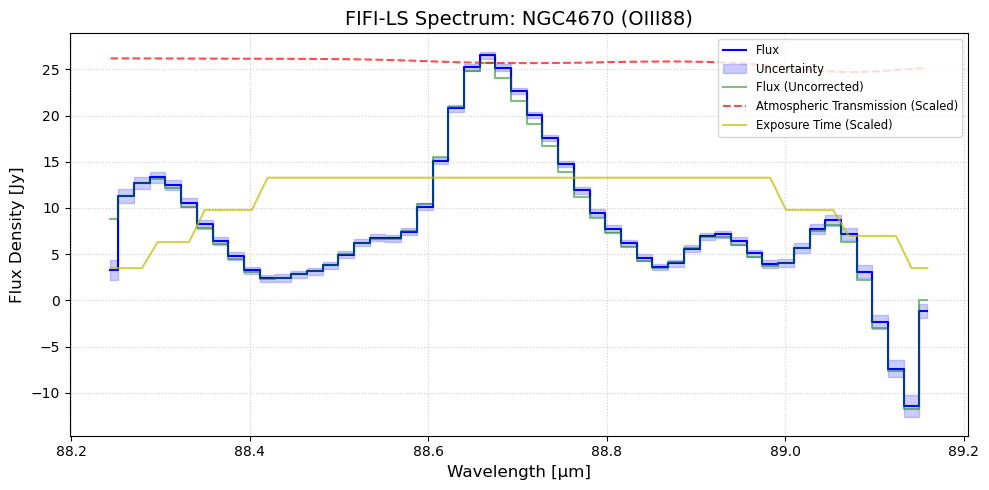

In [21]:
# Visualize Data 
fig, ax = plt.subplots(figsize=(10, 5))

# Plot primary spectral data
ax.step(wavelength, flux, color='b', linewidth=1.5, label='Flux', where='mid')
ax.fill_between(wavelength, flux - flux_unc, flux + flux_unc, color='b', alpha=0.2, step='mid', label='Uncertainty')
ax.step(wavelength, uncorr_flux, color='g', alpha=0.5, label='Flux (Uncorrected)', where='mid')

# Plot auxiliary data (Atmosphere and Exposure)
ax.plot(wavelength, atran_scaled, color='red', linestyle='--', alpha=0.7, label='Atmospheric Transmission (Scaled)')
ax.plot(wavelength, exposure_scaled, color='y', alpha=0.7, label='Exposure Time (Scaled)')

# Formatting
ax.set_title(f"FIFI-LS Spectrum: {Galaxy} ({Line})", fontsize=14)
ax.set_xlabel("Wavelength [µm]", fontsize=12)
ax.set_ylabel("Flux Density [Jy]", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(loc='upper right', fontsize='small', frameon=True)

plt.tight_layout()
plt.show()

In [22]:
# Extract data into arrays
y   = flux.to_numpy() # Flux
xx  = wavelength.to_numpy() # Wavelength
yerr= flux_unc.to_numpy() # Flux uncertainty

## 4. Continuum Fitting & Subtraction
Fitting a continuum establishes a baseline to ensure that the measured emission line flux represents only the gas signal, rather than the underlying starlight or dust. This sections perfoms a linear fit and subtraction to the continuum.

### User Inputs: Emission Line Boundaries ###

Looking at the plot above, define left and right boundaries for the emission line you are trying to fit in the cell below.

In [23]:
# User Inputs
left_bound = 88.45
right_bound = 88.87

In [24]:
# Define the emission line so we can exclude it and accurately fit the continuum
line_exclusion  = SpectralRegion([(left_bound*u.um, right_bound*u.um)])
unc      = StdDevUncertainty(yerr*u.Jy)                                   
spectrum = Spectrum(flux=y*u.Jy, spectral_axis=xx*u.um, uncertainty = unc)

# Fit the Continuum --> Use model=Chebyshev1D(1) to fit a linear continuum. If your baseline is curved, try Chebyshev1D(2).
g1_fit   = fit_generic_continuum(spectrum, median_window=3, model = Chebyshev1D(1),
                       fitter=LevMarLSQFitter(), exclude_regions=line_exclusion, weights=None)
y_continuum_fitted = g1_fit(xx*u.um)

# Create Subtracted and Normalized Spectra
spec_subtracted = spectrum - y_continuum_fitted
spec_normalized = spectrum / y_continuum_fitted
yy = spec_subtracted.data

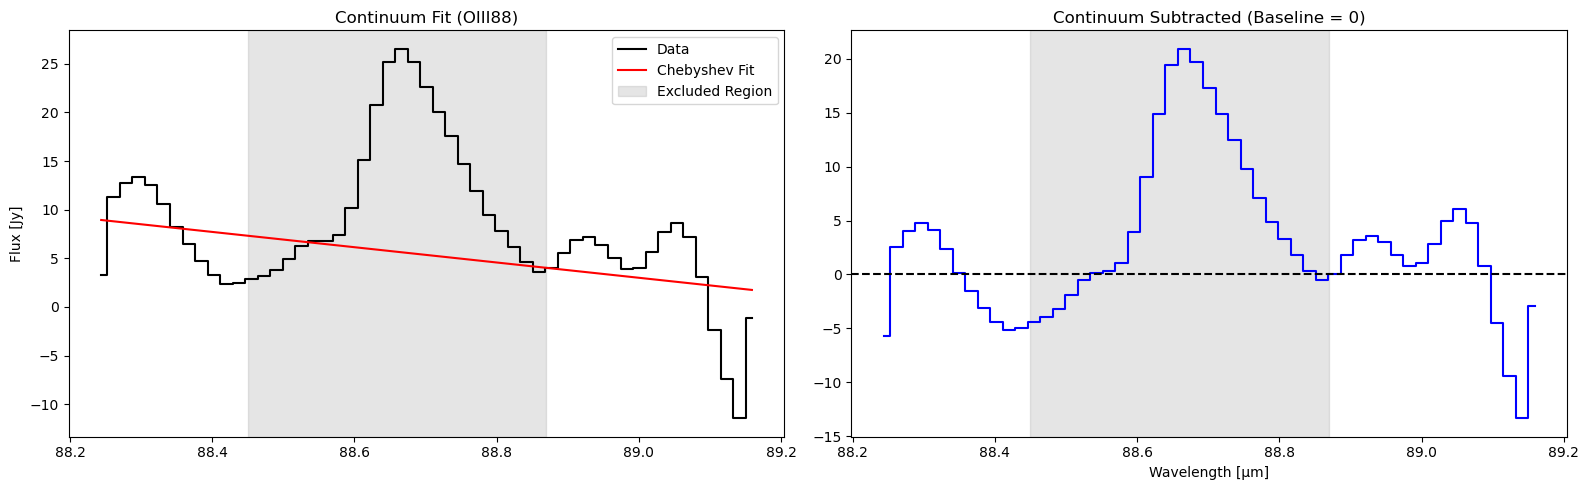

In [25]:
#Plot Continuum Fit & Subtraction

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left Plot: Raw Data + Fit
ax1.step(xx, y, color='black', label='Data', where='mid')
ax1.plot(xx, y_continuum_fitted, color='red', label='Chebyshev Fit')
ax1.axvspan(left_bound, right_bound, color='gray', alpha=0.2, label='Excluded Region')
ax1.set_title(f'Continuum Fit ({Line})')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

# Right Plot: Subtracted Data (The Line Profile)
ax2.step(xx, spec_subtracted.flux, color='blue', where='mid')
ax2.axhline(0, color='black', linestyle='--')
ax2.axvspan(left_bound, right_bound, color='gray', alpha=0.2)
ax2.set_title('Continuum Subtracted (Baseline = 0)')
ax2.set_xlabel('Wavelength [µm]')

plt.tight_layout()

## 5. Gaussian Fitting & Exporting Results
This section fits a Gaussian profile to the continuum-subtracted emission line. The error in the fit is calcuated, and the integrated flux is computed. The final results are exported to an output file.

### User Inputs: Mean, Amplitude, and Standard Deviation ###

You must provide estimates for the mean, amplitude, and standard deviation of the emission feature you are attempting to fit. This prevents the fitting algorithm from getting lost or settling on a mathematically possible but physically incorrect solution. Looking at the continuum subtracted plot above, estimate these values and record them in the cell below.

The commented-out lines (.min and .max) will force the fitter to stay within that range. If you have a particularly challenging data set, you may wish to utilize these parameters.


In [26]:
# User Inputs
mean = 88.7
amplitude = 25
stddev = 0.02

#gauss.mean.min      = 88
#gauss.mean.max      = 89
#gauss.amplitude.min = 3
#gauss.amplitude.max = 700
#gauss.stddev.min    = 0.001
#gauss.stddev.max    = 0.5

In [27]:
# Gaussian Fit Calculation
gauss = models.Gaussian1D(amplitude, mean, stddev)
fitter = fitting.LevMarLSQFitter()
model  = fitter(gauss, wavelength, yy)

y_Fitted  = model(wavelength)               # Jy
x_m       = wavelength*1e-6                 # meters
x_Hz      = c/(x_m)                         # Hertz
Lambda    = model.mean.value*1e-6           # meters
nu_Hz     = c/Lambda                        # Hertz

# Integration in frequency space
Y_Int1    = integrate.simpson(y_Fitted, x_Hz)   # Jy * Hz 
Flux1     = -Y_Int1*1e-26*(1e+16)             # [Jy * Hz] = 1e-26 W m^-2 sr

print ('Flux = %3.2f'%Flux1,'1e-16 w/m^2')

Flux = 10.86 1e-16 w/m^2


/var/folders/n5/btn1l3vs0wv48zg59gzrx2l80000gp/T/ipykernel_1254/1639981435.py:14: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  Y_Int1    = integrate.simps(y_Fitted, x_Hz) #- ------ LIZ VERSION


In [28]:
# Residuals and Noise Estimation
y_fit = model(xx)
y_residuals = yy - y_fit
rms_noise = np.std(y_residuals) 

# Spectral Geometry 
d_lambda_um = np.abs(xx[1] - xx[0])
d_lambda_m  = d_lambda_um * 1e-6
line_center_m = model.mean.value * 1e-6
d_nu_hz = d_lambda_m * (c / (line_center_m**2))

# Signal Integration Footprint (n)
fwhm_um = 2.355 * model.stddev.value
n_channels = fwhm_um / d_lambda_um

# Total Integrated Error Calculation
# 1e-26 converts Jy to W/m^2/Hz 
# 1e16 scales to units of 1e-16 w/m^2 
sigma_flux = (rms_noise * d_nu_hz * np.sqrt(n_channels)) * 1e-26 * 1e16

print(f"--- Results for {Galaxy} ---")
print(f"RMS Noise: {rms_noise:.4f} Jy")
print(f"Line Width (FWHM): {fwhm_um:.4f} µm ({n_channels:.2f} channels)")
print(f"Integrated Line Error: {sigma_flux:.6f} 1e-16 W/m^2")

--- Results for NGC4670 ---
RMS Noise: 3.6326 Jy
Line Width (FWHM): 0.1306 µm (7.43 channels)
Integrated Line Error: 0.663790 1e-16 W/m^2


<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n5/btn1l3vs0wv48zg59gzrx2l80000gp/T/ipykernel_1254/2424964955.py:23: SyntaxWarning: invalid escape sequence '\s'
  ax2.axhline(rms_noise, color='blue', linestyle=':', label='1-$\sigma$ RMS')


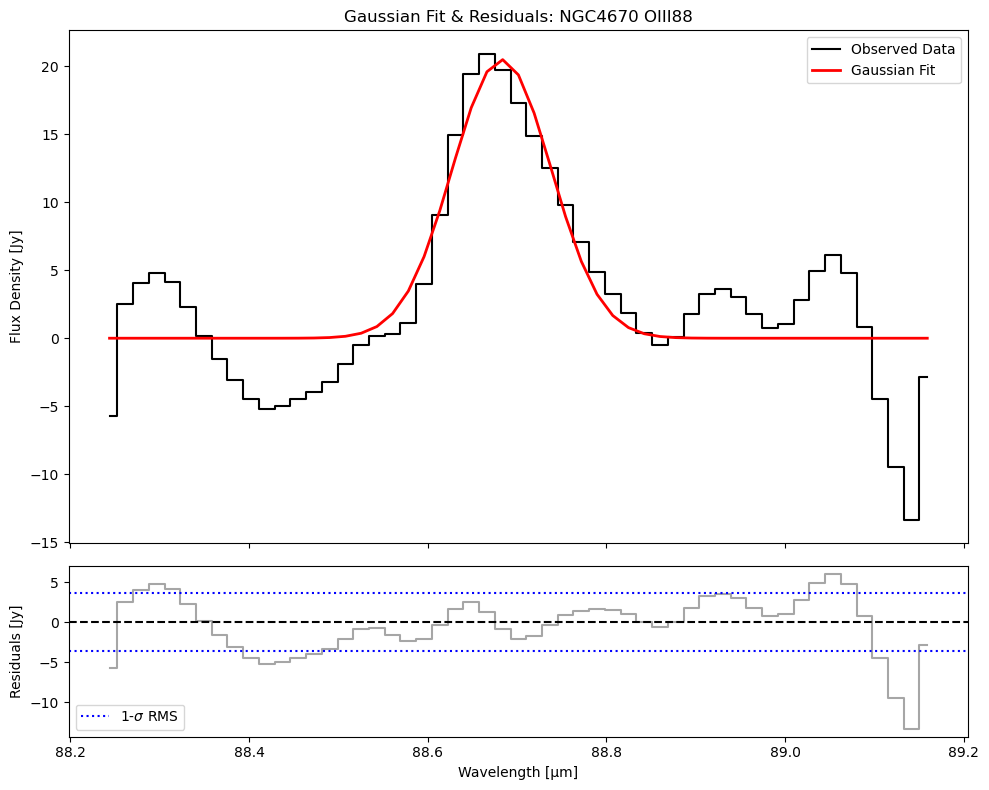

Figure saved → /Users/elizabethfletcher/Downloads/SOFIA_FIFI-LS_NGC4670_OIII88/data/SOFIA/FIFI-LS/L4/p12592/data/g4/results/NGC4670_OIII88_gaussian_fit_20260220.pdf


In [14]:
# Output directory (creates folder next to your data file if it doesn't exist)
output_dir = os.path.join(os.path.dirname(namef), "results")
os.makedirs(output_dir, exist_ok=True)

today = date.today().strftime("%Y%m%d")
fig_filename = f"{Galaxy}_{Line}_gaussian_fit_{today}.pdf"
fig_path = os.path.join(output_dir, fig_filename)

# Plotting Gaussian Fit & Residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# Top Plot: Data and Gaussian Fit
ax1.step(xx, yy, where='mid', color='black', label='Observed Data')
ax1.plot(xx, y_fit, color='red', linewidth=2, label='Gaussian Fit')
ax1.set_ylabel('Flux Density [Jy]')
ax1.legend()
ax1.set_title(f"Gaussian Fit & Residuals: {Galaxy} {Line}")

# Bottom Plot: Residuals (Noise)
ax2.step(xx, y_residuals, where='mid', color='gray', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--')
ax2.axhline(rms_noise, color='blue', linestyle=':', label='1-$\sigma$ RMS')
ax2.axhline(-rms_noise, color='blue', linestyle=':')
ax2.set_ylabel('Residuals [Jy]')
ax2.set_xlabel('Wavelength [µm]')
ax2.legend()

plt.tight_layout()
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved → {fig_path}")

In [16]:
# Export Results Summary

fwhm_km_s   = (fwhm_um / model.mean.value) * c / 1e3   # km/s
snr         = model.amplitude.value / rms_noise
flux_str    = f"{Flux1:.4f}"
err_str     = f"{sigma_flux:.4f}"

# save summary in txt file
txt_filename = f"{Galaxy}_{Line}_results_{today}.txt"
txt_path = os.path.join(output_dir, txt_filename)

summary_lines = [
    "=" * 52,
    f"  FIFI-LS Emission Line Fit Results",
    f"  {Galaxy}  |  {Line}  |  {today}",
    "=" * 52,
    "",
    "  GAUSSIAN PARAMETERS",
    f"    Amplitude   : {model.amplitude.value:.4f} Jy",
    f"    Line Center : {model.mean.value:.4f} µm",
    f"    Sigma       : {model.stddev.value:.4f} µm",
    f"    FWHM        : {fwhm_um:.4f} µm  ({fwhm_km_s:.1f} km/s)",
    "",
    "  INTEGRATED FLUX",
    f"    Flux        : {Flux1:.4f}  ×10⁻¹⁶ W m⁻²",
    f"    Error       : {sigma_flux:.4f}  ×10⁻¹⁶ W m⁻²",
    f"    SNR         : {snr:.1f}",
    "",
    "  NOISE",
    f"    RMS         : {rms_noise:.4f} Jy",
    f"    N Channels  : {n_channels:.1f}  (over FWHM)",
    "",
    "  CONTINUUM",
    f"    Model       : Chebyshev1D(1)",
    f"    Excl. Range : {left_bound} – {right_bound} µm",
    "",
    "=" * 52,
]

with open(txt_path, "w") as f:
    f.write("\n".join(summary_lines))

print(f"Summary saved  → {txt_path}")
print()
print("\n".join(summary_lines))

Summary saved  → /Users/elizabethfletcher/Downloads/SOFIA_FIFI-LS_NGC4670_OIII88/data/SOFIA/FIFI-LS/L4/p12592/data/g4/results/NGC4670_OIII88_results_20260220.txt

  FIFI-LS Emission Line Fit Results
  NGC4670  |  OIII88  |  20260220

  GAUSSIAN PARAMETERS
    Amplitude   : 20.4839 Jy
    Line Center : 88.6828 µm
    Sigma       : 0.0555 µm
    FWHM        : 0.1306 µm  (441.6 km/s)

  INTEGRATED FLUX
    Flux        : 10.8574  ×10⁻¹⁶ W m⁻²
    Error       : 0.6638  ×10⁻¹⁶ W m⁻²
    SNR         : 5.6

  NOISE
    RMS         : 3.6326 Jy
    N Channels  : 7.4  (over FWHM)

  CONTINUUM
    Model       : Chebyshev1D(1)
    Excl. Range : 88.45 – 88.87 µm

